<a href="https://colab.research.google.com/github/CHRISJUMA-9/Tensor-Flow-Fundamentals/blob/main/06_Build_More_Advanced_Models_with_TensorFlow_%5BMalaria_Diagnosis%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Build More Advanced Models with TensorFlow [Malaria Diagnosis]

- Sequential API
- Functional API
- Model Subclassing
- Custom Layers
- Callbacks
- CSVLogger
- Early Stopping
- Model Checkpointing
- Reduce Learning Rate On Plateau
- Model Evaluation and Testing
- Confusion Matrix
- (Receiver Operating Characteristic) ROC Plots
- Mittigation of Overfitting and Underfitting

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, InputLayer, BatchNormalization, Input, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2, l1
import pandas as pd
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
from google.colab import drive

In [ ]:
#Load the dataset
dataset, info = tfds.load("malaria", with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

In [ ]:
#Define a function for splitting the data
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [ ]:
#Spilt the data into train, validation, and test
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

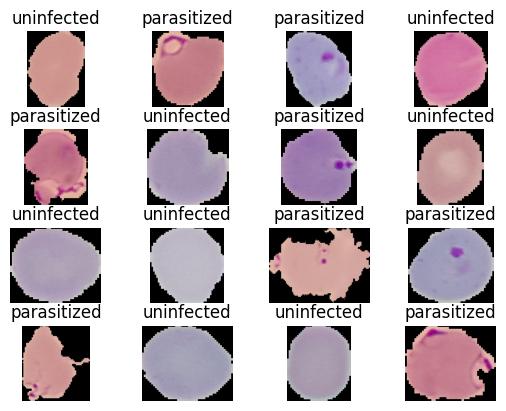

In [ ]:
#Let's do some data visualization
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image)
  plt.title(info.features['label'].int2str(label))
  plt.subplots_adjust(wspace=0.3, hspace=0.3)
  plt.axis('off')

In [ ]:
#Let's define a function for resizing and normalizing the images
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [ ]:
#Let's apply the resize and rescale function to our datasets and shuffle and batch our data
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

###Sequential API

In [ ]:
# Let's define a CNN using TensorFlow/Keras via the Sequential API
IM_SIZE = 224
dropout_rate = 0.3
regularization_rate = 0.01
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid',
           activation = 'relu', kernel_regularizer = l2(0.01)),
    BatchNormalization(),
    MaxPooling2D (pool_size = 2, strides= 2),
    Dropout(rate = dropout_rate),
    #Padding - adding extra pixels usually zeros around edges of input image
    #Valid padding means - no zero-padding output size shrinks

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid',
           activation = 'relu', kernel_regularizer = l2(0.01)),
    BatchNormalization(),
    MaxPooling2D (pool_size = 2, strides= 2),

    Flatten(), #Converts 3D output to 1D to feed into fully connected layers

    Dense(100, activation = "relu", kernel_regularizer = l2(0.01)),
    BatchNormalization(),
    Dropout(rate = dropout_rate),

    Dense(10, activation = "relu", kernel_regularizer = l2(0.01)),
    BatchNormalization(),

    Dense(1, activation = "sigmoid")
])
lenet_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

##Functional API

In [ ]:
# Let's create our functional API from teh Sequential API
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

#These Conv Layers extract possible features from the images

x = Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPooling2D (pool_size = 2, strides= 2)(x)

x = Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D (pool_size = 2, strides= 2)(x)

x = Flatten()(x)

# For classifying whethere image is parasitic or not

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input Image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

###Model Training

In [ ]:
#Let's calculate the binary cross-entropy loss between the true labels(y_true) and predicted probabilities (y_pred)
y_true = [0, 1, 0, 0]
y_pred = [0.6, 0.51, 0.94, 1]
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=5.086357593536377>

In [ ]:
# Let's compile our model
lenet_model_func.compile(optimizer = Adam(learning_rate = 0.01),
              loss = BinaryCrossentropy(),
              metrics = ['accuracy'])

In [ ]:
#Let's fit our model
history = lenet_model_func.fit(train_dataset, validation_data=val_dataset, epochs = 5, verbose = 1)

Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 48s 60ms/step - accuracy: 0.8088 - loss: 0.4238 - val_accuracy: 0.9296 - val_loss: 0.1985
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 81s 64ms/step - accuracy: 0.9257 - loss: 0.2101 - val_accuracy: 0.8465 - val_loss: 0.4509
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 76s 55ms/step - accuracy: 0.9348 - loss: 0.1952 - val_accuracy: 0.9412 - val_loss: 0.1717
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 46s 66ms/step - accuracy: 0.9444 - loss: 0.1671 - val_accuracy: 0.9292 - val_loss: 0.2041
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 73s 54ms/step - accuracy: 0.9445 - loss: 0.1664 - val_accuracy: 0.5568 - val_loss: 0.5758


###Feature Extractor Model

In [ ]:
# Let's build a feature extractor model
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPooling2D (pool_size = 2, strides= 2)(x)

x = Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(x)
x = BatchNormalization()(x)
output = MaxPooling2D (pool_size = 2, strides= 2)(x)

feature_extractor_model = Model(func_input, output, name = "Feature_Extractor")
feature_extractor_model.summary()

Model: "Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input Image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,136 (4.44 KB)

 Trainable params: 1,092 (4.27 KB)

 Non-trainable params: 44 (176.00 B)

In [ ]:
# Note we can create our model using the combination of fdifferent models suchas Sequential and Functionla API

feature_extractor_seq_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D (pool_size = 2, strides= 2),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D (pool_size = 2, strides= 2),
])

feature_extractor_seq_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,136 (4.44 KB)

 Trainable params: 1,092 (4.27 KB)

 Non-trainable params: 44 (176.00 B)

###Callable Model
- i.e model that can be used like a regular Python function.
- You can "call" with input data to get predictions or output

In [ ]:
# Let's simplify our feature extractor model
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

#These Conv Layers extract possible features from the images

x = feature_extractor_seq_model(func_input)

x = Flatten()(x)

# For classifying whether image is parasitic or not

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input Image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 54, 54, 16)     │         1,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

##Model Subclassing

In [ ]:
# Let's extract and downsample image features using conv, batch norm, and pooling layers.
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(FeatureExtractor, self).__init__() #calling the constructor of the parent class tf.keras.layers.Layer

    self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPooling2D (pool_size = pool_size, strides= 2*strides)

    self.conv_2 = Conv2D(filters = filters*2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPooling2D (pool_size = pool_size, strides= 2*strides)

  def call(self, x, training=False):

      x = self.conv_1(x)
      x = self.batch_1(x, training=training)
      x = self.pool_1(x)

      x = self.conv_2(x)
      x = self.batch_2(x, training=training)
      x = self.pool_2(x)

      return x
feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [ ]:
# Now let's use it in our model
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_sub_classed(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input Image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_extractor               │ (None, 54, 54, 16)     │         1,488 │
│ (FeatureExtractor)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,649 (17.81 MB)

 Trainable params: 4,668,381 (17.81 MB)

 Non-trainable params: 268 (1.05 KB)

In [ ]:
# Let's create a model
class LenetModel(Model):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size,):
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation = "relu")
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation = "relu")
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation = "sigmoid")

  def call(self, x, training=False):
    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x

lenet_sub_classed = LenetModel(8, 3, 1, "valid", "relu", 2)
lenet_sub_classed(tf.zeros([1,224,224,3]))
lenet_sub_classed.summary()



Model: "lenet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_extractor_1             │ ?                      │         1,488 │
│ (FeatureExtractor)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (1, 46656)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (1, 100)               │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (1, 100)               │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (1, 10)                │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (1, 10)                │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (1, 1)                 │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,649 (17.81 MB)

 Trainable params: 4,668,381 (17.81 MB)

 Non-trainable params: 268 (1.05 KB)

In [ ]:
# Let's compile our model
lenet_sub_classed.compile(optimizer = Adam(learning_rate = 0.01),
                         loss = BinaryCrossentropy(),
                         metrics = ['accuracy'])

In [ ]:
history = lenet_sub_classed.fit(train_dataset, validation_data=val_dataset, epochs = 5, verbose = 1)

Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 53s 69ms/step - accuracy: 0.7789 - loss: 0.4552 - val_accuracy: 0.8011 - val_loss: 0.3993
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 37s 54ms/step - accuracy: 0.9353 - loss: 0.1959 - val_accuracy: 0.7717 - val_loss: 0.7825
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - accuracy: 0.9415 - loss: 0.1800 - val_accuracy: 0.9456 - val_loss: 0.1941
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step - accuracy: 0.9473 - loss: 0.1673 - val_accuracy: 0.5307 - val_loss: 0.8316
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 42s 56ms/step - accuracy: 0.9513 - loss: 0.1471 - val_accuracy: 0.5869 - val_loss: 0.6390


##Custom Layers

In [ ]:
# Let's create a neural dense linear transformation (x@w+b)
class NeuralearnDense(Layer):
  def __init__(self, output_units, activation):
    super(NeuralearnDense, self).__init__()
    self.output_units = output_units
    self.activation = activation

  def build(self, input_features_shape):
    self.w = self.add_weight(shape = (input_features_shape[-1], self.output_units), initializer = "random_normal", trainable = True)
    self.b = self.add_weight(shape = (self.output_units,), initializer = "random_normal", trainable = True)

  def call(self, input_features):

    pre_output = tf.matmul(input_features, self.w) + self.b

    if(self.activation == "relu"):
      return tf.nn.relu(pre_output)
    elif(self.activation == "sigmoid"):

      return tf.math.sigmoid(pre_output)
    else:
      return pre_output

In [ ]:
# Let's define a CNN using TensorFlow/Keras via the Sequential API
IM_SIZE = 224
lenet_custom_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D (pool_size = 2, strides= 2),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D (pool_size = 2, strides= 2),

    Flatten(),
    NeuralearnDense(100, "relu"),
    BatchNormalization(),

    NeuralearnDense(10, "relu"),
    BatchNormalization(),

    NeuralearnDense(1, "sigmoid")
])
lenet_custom_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ neuralearn_dense                │ (None, 100)            │     4,665,700 │
│ (NeuralearnDense)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ neuralearn_dense_1              │ (None, 10)             │         1,010 │
│ (NeuralearnDense)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ neuralearn_dense_2              │ (None, 1)              │            11 │
│ (NeuralearnDense)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

#Callbacks

In [ ]:
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print("\n For Epoch Number {} the model has a loss of {} ".format(epoch+1, logs["loss"]))

 # def on_batch_end(self, batch, logs):
   # print("\n For Batch Number {} the model has a loss of {} ".format(batch+1, logs))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##CSVLogger

In [ ]:
# Let's set a CSV logger callback (logs training metrics like loss and accuracy to a csv file after each epoch)
#csv_callback = CSVLogger(
   # 'logs.csv', separator=',', append=False #append false overwrites the file if it exists
#)

##EarlyStopping

In [ ]:
# Let's run the early stopping
es_callback = EarlyStopping(
    monitor='val_loss',         # Watch the validation loss metric
    min_delta=0,                # Consider an improvement only if the new loss is at least 0 less than the previous best (i.e., any improvement counts)
    patience=2,                 # Allow 2 epochs without improvement before stopping
    verbose=1,                  # Print a message when training is stopped early
    mode='auto',                # Automatically choose whether to minimize or maximize the monitored value (min for 'val_loss')
    baseline=None,              # No predefined baseline value to meet
    restore_best_weights=False # Do not restore the model weights from the best epoch after stopping
)


###LearningRateScheduler

In [ ]:
#Let us define our LearningRate Scheduler
def scheduler(epoch, lr):
  if epoch < 3:  # Keep learning rate constant for the first 3 epochs
    return lr
  else:
    return (lr * tf.math.exp(-0.1)).numpy() # After epoch 10, exponentially decay the learning rate
scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

##ModelCheckpointing

In [ ]:
#Let's do modelcheckpointing
#This saves the model or its weights at specific intervals such as after epochs
checkpoint_callback = ModelCheckpoint(
    'checkpoints/best_model.keras', monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
)

##ReduceLearingRateOnPlateau

In [ ]:
# Let's look at reuding learning rate at plateau
# Reduces the learning rate if teh model stops improving
plateau_callback = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=2, verbose=1
)

###Precision, Recall, and Accuracy

In [ ]:
#Let's define the metrics to obatin the additional parameters
metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
           BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [ ]:
#Let's compile the model
lenet_custom_model.compile(optimizer = Adam(learning_rate = 0.01),
                          loss = BinaryCrossentropy(),
                          metrics = metrics)

In [ ]:
#Let's fit the model
history = lenet_custom_model.fit(train_dataset, validation_data=val_dataset, epochs = 10, verbose = 1, callbacks = [plateau_callback,checkpoint_callback,es_callback,scheduler_callback,])
# to get the 689 we take the datasize/32


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 52s 65ms/step - accuracy: 0.9790 - auc: 0.9966 - fn: 106.2696 - fp: 137.6652 - loss: 0.0619 - precision: 0.9760 - recall: 0.9823 - tn: 5381.0640 - tp: 5430.9492 - val_accuracy: 0.9354 - val_auc: 0.9724 - val_fn: 105.0000 - val_fp: 73.0000 - val_loss: 0.2391 - val_precision: 0.9463 - val_recall: 0.9245 - val_tn: 1291.0000 - val_tp: 1286.0000 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 74s 57ms/step - accuracy: 0.9816 - auc: 0.9978 - fn: 89.3841 - fp: 121.4971 - loss: 0.0533 - precision: 0.9792 - recall: 0.9843 - tn: 5397.2944 - tp: 5447.7725 - val_accuracy: 0.9191 - val_auc: 0.9651 - val_fn: 161.0000 - val_fp: 62.0000 - val_loss: 0.3157 - val_precision: 0.9519 - val_recall: 0.8839 - val_tn: 1306.0000 - val_tp: 1226.0000 - learning_rate: 0.0100

Epoch 3: LearningRateSchedul

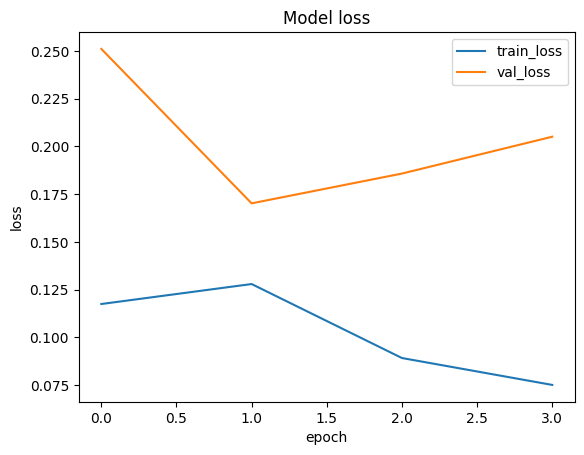

In [ ]:
# Let's visualize the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

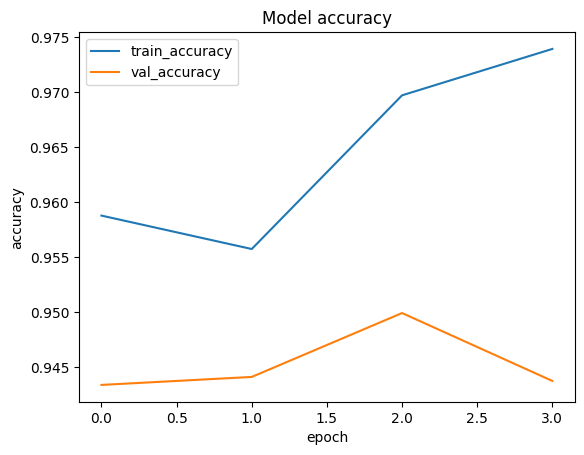

In [ ]:
# Let's visualize the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

##Model Evaluation and Testing

In [ ]:
# Let's evaluate our model
test_dataset = test_dataset.batch(1)

In [ ]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [ ]:
#Let's evaluate the data set
lenet_custom_model.evaluate(test_dataset)

2757/2757 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9398 - auc: 0.9754 - fn: 27.1882 - fp: 56.6896 - loss: 0.1830 - precision: 0.9244 - recall: 0.9604 - tn: 628.3256 - tp: 667.2962


[0.18387824296951294,
 1313.0,
 119.0,
 1271.0,
 54.0,
 0.9372506141662598,
 0.9168994426727295,
 0.9604974389076233,
 0.9762921333312988]

##Confusion Matrix

###Visualizing Confusion Matrix

In [ ]:
# Let's extracts all data from the TensorFlow dataset and stores it in two separate Python lists
labels = [] #will store the target/output values (y)
inp = [] #will store the input data (x)

for x,y in test_dataset.as_numpy_iterator(): #Converts a TensorFlow dataset into a Python iterator that yields NumPy arrays (instead of Tensors).
  labels.append(y)
  inp.append(x)

In [ ]:
# Let's print the codes of the numpy array extracted from tensorflow and determine their shape
print(np.array(inp).shape)
print(np.array(inp)[:,0,...].shape)

(2757, 1, 224, 224, 3)
(2757, 224, 224, 3)


In [ ]:
#Let's print oput the 1D NimPy array of label values
labels = np.array([i[0] for i in labels])
print(labels)

[1 0 0 ... 1 0 1]


In [ ]:
#Now lets make our prediction
predicted = lenet_custom_model.predict(np.array(inp)[:,0,...])
print(predicted[:,0])

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
[0.93664056 0.01670765 0.00966962 ... 0.9617128  0.01356203 0.92074555]


[[1330   66]
 [ 154 1207]]


Text(0.5, 58.7222222222222, 'Predicted')

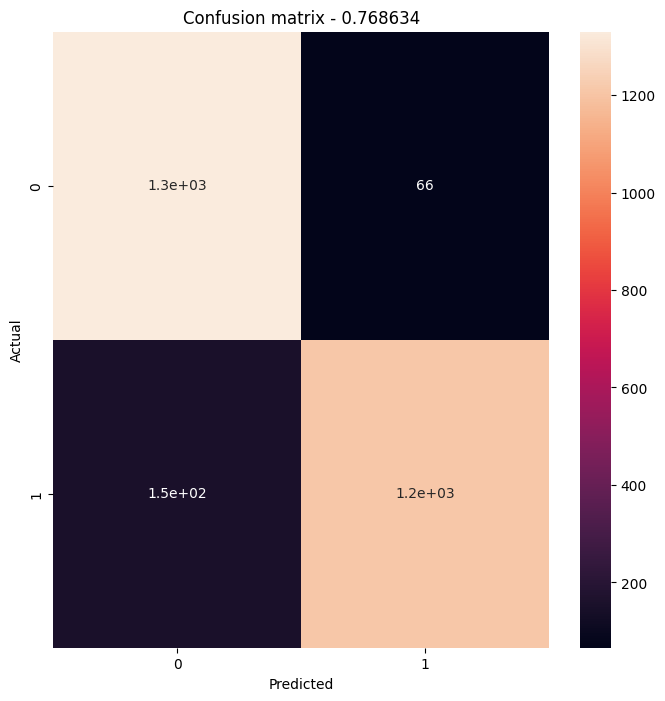

In [ ]:
threshold = 0.768634 #sets the decision threshold

#Predictions greater than 0.5 will be considered positive (1), otherwise negative (0).

cm = confusion_matrix(labels, predicted > threshold)
print(cm)

plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

###(Receiver Operating Characteristic) ROC Plots

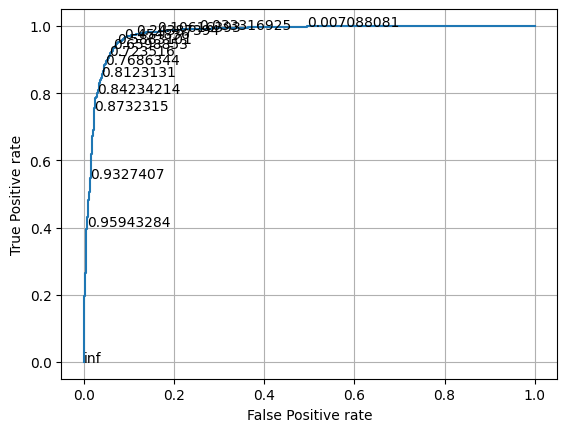

In [ ]:
#Let's calculate FP, TP at each threshold then show
fp, tp, thresholds = roc_curve(labels, predicted)
plt.plot(fp, tp)
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")

plt.grid()

skip = 20

for i in range(0, len(thresholds), skip):
  plt.text(fp[i], tp[i], thresholds[i])

plt.show()

#Mitigating overfitting and underfitting



* **Overfitting**: Model learns too much (including noise)
* **Underfitting**: Model fails to learn enough

---

### ✅ Table: Techniques to Mitigate **Overfitting**

| **Cause of Overfitting**                | **Mitigation Technique** | **Description**                                                   |
| --------------------------------------- | ------------------------ | ----------------------------------------------------------------- |
| Model is too complex                    | Simplify the model       | Reduce number of layers, neurons, or parameters                   |
| Model learns noise in training data     | Regularization (L1/L2)   | Penalizes large weights, encourages simpler models                |
| Reliance on specific neurons            | Dropout                  | Randomly drops neurons during training                            |
| Model fits training data too closely    | Early Stopping           | Stops training when validation performance stops improving        |
| Insufficient training data              | Data Augmentation        | Increases data variety using transformations (flip, rotate, etc.) |
| High variance in validation performance | Cross-Validation         | Evaluates model on multiple data subsets                          |
| Too many training epochs                | Reduce training time     | Shorten number of epochs                                          |
| Small or noisy dataset                  | Add more training data   | Helps generalize better and avoid memorization                    |

---

### ✅ Table: Techniques to Mitigate **Underfitting**

| **Cause of Underfitting**             | **Mitigation Technique**  | **Description**                                            |
| ------------------------------------- | ------------------------- | ---------------------------------------------------------- |
| Model is too simple                   | Increase model complexity | Add more layers, neurons, or use more advanced models      |
| Model hasn't trained enough           | Train longer              | Increase number of training epochs                         |
| Regularization too strong             | Reduce regularization     | Lower L1/L2 penalty to allow more flexible learning        |
| Dropout too aggressive                | Reduce or remove dropout  | Keep more neurons active for full learning capacity        |
| Poor feature quality                  | Feature engineering       | Extract better or more meaningful features                 |
| Learning rate too low                 | Tune learning rate        | Adjust the rate to allow the model to converge effectively |
| Input data too noisy or uninformative | Clean and preprocess data | Remove noise, correct errors, or engineer better features  |


